# Car reviews Classifier

Creation of car review classifiers.
Part one is a Naive-Bayes classifier.
Part two extends previous classifier and add aditional models to compare.

Notes:

It is important to avoid issues of data leakage, meaning that the classifier should only
be trained using data that it has access to from within the training data set. If there are words
that only appear in the test data they should not be part of the classifier. 

The code is able to deal with encountering words in the test data that the
classifier has not seen in the training data. 

The code will read the raw data CSV file provided.

The sentiment classifier uses a bag of words technique, in which it builds a vocabulary of individual words that appear in the dataset once it has been cleaned up.

Model treats minor variations of a word (e.g. fault, faults and faulty) as instances of
the same word (e.g. fault).

Each review creates a vector as input for your classifier, containing either binary values indicating whether a word/stem occurs in the review.

As described above, vectors that are used to train the classifier should only include words that appear in the training data (and not words that only exist within the test data)


# PART ONE - Car Review Classifier

### Libraries

The following cells present the needed libraries that I used to run / execute this Jupyter notebook, please run the following cell to download them, uncomment all those that your computer already has or add their modules in case you do not have them

In [1]:
##########    Contractions    ##########
# Microsoft Visual C++ 13 or lower
!pip install contractions==0.0.18

# Microsoft Visual C++ 14 greater
#!pip install contractions==0.0.58


##########    Spellcheckers    ##########
# NLTK
!pip install nltk

# Microsoft autocorrect
!pip install autocorrect

# Microsoft Textblob
!pip install textblob

# Microsoft Pyspellchecker
!pip install pyspellchecker


##########    Stopwords & Stemmer/lemmatizer    ##########
# Spacy
!pip install spacy

In [2]:
import copy
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.naive_bayes import MultinomialNB

import spacy
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
import re
import contractions

from nltk.metrics.distance import jaccard_distance
from nltk.util import ngrams
from nltk.corpus import words
from autocorrect import Speller
from textblob import TextBlob
from spellchecker import SpellChecker

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns
import matplotlib.pyplot as plt

### Class and Methods

Now, I created a class which is used performs the first sections in our Data Science pipeline, in order to standardize the given data and process it in a way that we can use to implement the bag of words and Naive-Bayes classifier or others.
Inside this class we have methods to process both variables: Inputs and Outputs (also known as X and Y, respectively). 
The process that inputs follow is:
1. Replace contractions such as: dont --> do not, isnt --> is not, etc
2. Tokenize / split the text by using n-grams, the default value is 1 or unigram, which was used for this part one, so the output for this method will be a list with only one word in each element.
3. Standardize the inputs by excluding numbers, punctions or other symbols, using spell checkers, excluding words that are not representative for our cases and finally multiple stemmers and lemmatizers from two libraries (NLTK and Spacy).

Parameters for:

a.	spellchecker:
The default value for this parameter is None, which means that we will not use any checker at this part, other checkers will be visited in part two, but here you can see all the methods used in the assignment, whose main objective is to predict or correct (through dictionaries or algorithms) a misspelled word.
Values:
“NLTK_jaccard" by NLTK library
"autocorrect" by autocorrect library
"Textblob" by textblob library
"pyspellchecker" by pyspellchecker library 
                
b.	Excluding_words:
The default value for this parameter is “Spacy” that means that we use the library Spacy and its dictionaries to delete words from our data, on the other hand the other tool used is NLTK stop_words method. More in detail in Part two.
Values:
“Spacy”
“NLTK”

c.	Stemmer / Lemmatizer:
The default value for this parameter is “NLTK_lemmatizer” by NLTK, but we can see other lemmatizer method, this time by Spacy library. I also used stemmers, to be more specific 2 of them: Porterstemmer and SnowballStemmer. More in the next section.
Values:
"NLTK_lemmatizer"
“Spacy”
“NLTK_stemmer"
"NLTK_snowball_stemmer"

On the other hand, the process that output (Y values) follow is simpler than previous one, they are changed or encoded to 0s or 1s based on the categorical targets (Negative or Positive), where 1 is Positive and 0 is Negative for our purpose.



In [3]:
# Class

class Data_Ingestion_Processed():
    
# STEP 1
#
    def __init__(self, data):
        self.data = data
        self.headers = self.data.columns.to_list() # Getting the names of the columns
        
# STEP 2
#   Getting the X and Y values in lists for training_data
    def split_IN_OUT(self, data):
        
        data = data.apply(lambda x: x.astype(str).str.lower()) # Change to lower case
        
        data_Y = data[self.headers[0]]
        data_X = data[self.headers[1]].to_list()
        
        return data_Y, data_X
    
# STEP 2.1
#
    def encoding_categorical_targets(self, y):

        Y=pd.get_dummies(y)
        Y=Y.iloc[:,1].values
        
        return Y

# STEP 3 
#    Replace contractions in string of text

    def replace_contractions(self, data_X):
        
        for i in range(len(data_X)):
            data_X[i] = contractions.fix(data_X[i]) 
   
        return data_X
           
# STEP 4    
#   Splitting each word as elements in a list and use of ngrams: unigram as default
    def tokenaizer(self, data_X, num = 1):
        
        data_X_tokenaize = copy.deepcopy(data_X)
                
        for i in range(len(data_X)):
            n_grams = ngrams(nltk.word_tokenize(data_X[i]), num)
            data_X_tokenaize[i] = [ ' '.join(grams) for grams in n_grams]

        return data_X_tokenaize
    
# STEP 5
#   Excluding words and punctuations
    def excluding_data(self, data_X, stop_words, stemmer, spell_checker):
        
        excluded_features_data_X = copy.deepcopy(data_X)

        for i in range(len(data_X)):
            excluded_features_data_X[i] = self.excluding_numbers(data_X[i]) # Calling function to swap numbers to dots.
            excluded_features_data_X[i] = self.excluding_punctuations(excluded_features_data_X[i]) # Calling function to delete punctuation.
            excluded_features_data_X[i] = self.spellchecker(excluded_features_data_X[i], spell_checker) 
            excluded_features_data_X[i] = self.excluding_words(excluded_features_data_X[i], stop_words) # Calling function to delete words
            excluded_features_data_X[i] = self.lemmatizing_words(excluded_features_data_X[i], stemmer) # Calling function to delete words
            
        excluded_data_X = self.list2str(excluded_features_data_X) # Converting to str again
       
        return excluded_data_X

# STEP 5.1
#
    def excluding_numbers(self, features):
        
        new_features = copy.deepcopy(features)
        
        for i in range(len(features)):
            for j in range(len(features[i])):
                if features[i][j].isdigit():
                    new_features[i] = "."
                        
        return new_features
    
# STEP 5.2
# 
    def excluding_punctuations(self, features):
        
        for i in range(len(features)):
            features[i] = re.sub(r'[^\w\s]','',features[i])
            
        new_features = []
        
        for word in features:
            if word != "":
                new_features.append(word)
                
        
        return new_features
    
#
    def spellchecker(self, features, spell_checker = None):
        
        new_features = []
        
        if spell_checker == None:
            return features
            
        if spell_checker == "NLTK_jaccard":
            correct_words = words.words()
            
            for word in features:
                temp = [(jaccard_distance(set(ngrams(word, 1)), set(ngrams(w, 1))),w) for w in correct_words if w[0]==word[0]]

                new_features.append(sorted(temp, key = lambda val:val[0])[0][1])
                
        if spell_checker == "autocorrect":
            spell = Speller(lang='en')
           
            for word in features:
                new_features.append(spell(word))
                
        if spell_checker == "Textblob":
            for word in features:
                new_features.append(str(TextBlob(word).correct()))
                
        if spell_checker == "pyspellchecker":
            spell = SpellChecker()
            for word in features:
                new_features.append(spell.correction(word))
                
        return new_features

# STEP 5.3   
#   Using NLTK corpus library
    def excluding_words(self, features, stop_words = None):
        
        if stop_words == None:
            stop_words = "Spacy"
        
        if stop_words == "Spacy":
            #Spacy
            new_features = []
            nlp = English()

            for word in features:
                lexeme = nlp.vocab[word]

                if lexeme.is_stop == False:
                    new_features.append(word)
                    
        if stop_words =="NLTK":
            #NLTK
            new_features = copy.deepcopy(features)
            stop_words = set(stopwords.words('english')) # Using stopwords in englisg language
    
            for i in range(len(features)):
                for word in stop_words:
                    if word.lower() == features[i]:
                        new_features.remove(features[i])

        return new_features # A clean list is returned

# STEP 5.4  
#   Using NLTK lemmatizer library
    def lemmatizing_words(self, features, stemmer = None):
        
        if stemmer == None:
            stemmer = "NLTK_lemmatizer"
        
        if stemmer == "Spacy":
            # Spacy
            new_features =[]
            sp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

            for i in range(len(features)):
                doc = sp(features[i])

                for token in doc:
                    new_features.append(token.lemma_)
        
        if stemmer == "NLTK_stemmer":
            stemmer = PorterStemmer()
            new_features = self._stemmer(features, stemmer)
            
        if stemmer == "NLTK_snowball_stemmer":
            sn_stemmer = SnowballStemmer("english")
            new_features = self._stemmer(features, sn_stemmer)
            
        if stemmer == "NLTK_lemmatizer":
            lemmatizer_features = []
            lemmatizer = WordNetLemmatizer()
            
            for word in features:
                lemmatizer_features.append(lemmatizer.lemmatize(word)) 
            new_features = lemmatizer_features
            
        return new_features # A clean list is returned
    
# STEP 5.4.1
#   Different stemmer for NLTK function
    def _stemmer(self, features, model):
        
        stemmer_features = []
        
        for word in features:
            stemmer_features.append(model.stem(word)) 
            
        return stemmer_features # A clean list is returned

# STEP 5.5
#   Converting all elements in the list into a string element
    def list2str(self,_list):
        
        str_list = copy.deepcopy(_list)
        
        for i in range(len(_list)):
            str_list[i] = " ".join(_list[i])
        
        return str_list

### Functions

Then, we have the split_dataset_train_test function to split the data into Training and Test set, whose parameters are the complete raw data and training data ratio, in this case this value is assigned by the processing_data function (0.80). 

The purpose of the processing_data function is as its name says; take the raw data and standardize it as we saw previously, returning two lists: a list of cleaned words and the encoded values of the outputs (Y vales).

The parameters that this function takes are: 
1. data: Raw Data (Inputs / Outputs)
2. num_grams: Integr number for n-grams (1,2,3,4,...)
3. stop_words: A string variable that use the funcion based on the library selected (“Spacy”, “NLTK”). (Previously described on Class and Methods)
4. stemmer: A string variable that use the funcion based on the library selected ("NLTK_lemmatizer", “Spacy”, “NLTK_stemmer", "NLTK_snowball_stemmer"). (Previously described on Class and Methods)
5. spell_checker: A string variable that use the funcion based on the library selected (“NLTK_jaccard", "autocorrect", "Textblob", "pyspellchecker"). (Previously described on Class and Methods)

If you want to process the data separatetly at the end of the notebook, you can find an example and the functions for inputs and outputs (Check Extra comments)

In [4]:
#Functions

def split_dataset_train_test(data, training_data_ratio):
    data_frame = pd.read_csv(data)
    training_data, testing_data = train_test_split(data_frame, train_size = training_data_ratio, random_state = 2, shuffle = True)
    return training_data, testing_data 
    
def processing_data(data, num_grams, stop_words, stemmer, spell_checker):
    
    processed_data = Data_Ingestion_Processed(data) # Creating the object for training data
    data_Y, data_X = processed_data.split_IN_OUT(data) # Splitting X data and Y data
    encoded_data_Y = processed_data.encoding_categorical_targets(data_Y) # Encoding target values Y data
    data_X = processed_data.replace_contractions(data_X) # Processing contractions 
    data_X_tokenaize = processed_data.tokenaizer(data_X, num_grams) # Tokenaizing the text
    excluded_features_data_X = processed_data.excluding_data(data_X_tokenaize, stop_words, stemmer, spell_checker) # Excluding words, numbers, punctuations and returning a string
    return excluded_features_data_X, encoded_data_Y
        

### Main

Finally, we execute all described above and create the bag of words with the numbers of times that a word was repeated by using the CountVectorizer method from scikitleran library and then we transform the result in a numpy array. There is another method called "TfidfTransformer", which transform a count matrix to a normalized term-frequency  or term-frequency times representation, scaling down the impact of tokens that occur very frequently in a given text and that are hence empirically less informative than features that occur in a small fraction of the training features. So, by using this technique we would have decimals instead of integers, but this notebook just present the CountVectorizer method. One interesting thing is that we can see all words listed in both techniques with get_feature_names.

Then, I printed the full bag of words for the firsts three random reviews.

In [5]:
################### Main ######################

DATA = "car-reviews.csv"
training_data, testing_data = split_dataset_train_test(DATA, training_data_ratio = 0.8) #Splitting Data
# Normalizing trainig data
train_X_text, train_Y = processing_data(training_data, num_grams = 1, stop_words = "Spacy", stemmer = "NLTK_lemmatizer", spell_checker = None) # Process and Normalize both "Features" X_Data and "Target values" (Y_Data)
# Bag of words
vectorizer = CountVectorizer() # Initializing the Object 
train_X_vector = vectorizer.fit_transform(train_X_text).toarray() # Transforming to bag of words
train_features = vectorizer.get_feature_names() # All words in a list
#print()
#print(train_features)
#print(len(train_features))

np.set_printoptions(threshold=np.inf)
print(train_X_vector[:3]) # Printing the first 3 reviews: Array that contains the number of times a word is repeated
print("\nDone")

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

The same process was implemented for test data, in this point we looked at unseen data, so the object for the test data will be the same that in training data or we can import the bag of words from training data into a new object in test data, both cases are the same to manage unseen data and avoid data leakage.

In [6]:
# Normalizing testing data
test_X_text, test_Y = processing_data(testing_data, num_grams = 1, stop_words = "Spacy", stemmer = "NLTK_lemmatizer", spell_checker = None) # Process and Normalize both "Features" X_Data and "Target values" (Y_Data)X_Data and "Target values" (Y_Data)
test_X_vector = vectorizer.transform(test_X_text).toarray() # Transforming to bag of words
test_features = vectorizer.get_feature_names() # All words in a list
#print(len(test_features))
np.set_printoptions(threshold=np.inf)
print(test_X_vector[:3])
print("\nDone")

[[ 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  1  0  0  0  0  0
   1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0 

###  Naive-Bayes and K-fold Cross Validation

Now, let´s talk about the classifier. At this instance we only need to provide the bag of words from Training set to the Naïve-Bayes classifier. Once that, we can easily request the accuracy / score for this data, however a good practice is the use of K-fold cross validation to avoid overfitting by using only the training set, this process divides a limited dataset into K non-overlapping folds, creating this way the K validation sets.

Each of the K folds is given an opportunity to be used as a held back test set, whilst all other folds collectively are used as a training dataset. A total of K models are fit and evaluated on the K validation sets and the mean performance is reported. 

Here, there is a good point to mention: each time the procedure is run, a different split of the dataset into k-folds  is implemented,  the results / scores can be different, one solution to reduce the noise in the estimated model performance is to increase the k-value, decreasing the bias, although the variance will be increased.

In order to avoid that, repeating the k-fold cross-validation process multiple times is a good way to face this issue, this way I used the method “repeated k-fold cross-validation” and to keep the same proportion about 80 / 20 for training & test sets, the K versions will be 5  and the repeats are 3 (common numbers of repeats include 3, 5, and 10), all this as result of the process can take some time for our data and we need to repeat 15 times (5 x 3), and to be repeatable the result each time I used a random_state = 1.


In [7]:
# Naive Bayes Solution

modelNB = MultinomialNB()
modelNB.fit(train_X_vector, train_Y)

# Checking the performance of the model with K -Fold validation K = 10 and 3 repeats (total of 30 differnt combinations)
cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
scores = cross_val_score(modelNB, train_X_vector, train_Y, scoring='accuracy', cv=cv, n_jobs=-1)
print(f"The Accuracy of the model with K-Fold Cross Validation and Naive-Bayes Model is: {100 * scores.mean():.2f}%")
print()
print(f"The Accuracy of of the model with Testing Data and Naive-Bayes Model is: {100 * modelNB.score(test_X_vector, test_Y):.2f}%")

The Accuracy of the model with K-Fold Cross Validation and Naive-Bayes Model is: 76.80%

The Accuracy of of the model with Testing Data and Naive-Bayes Model is: 78.70%


### Confusion Matrix

Finally, we can create a confusion matrix, which is a table layout that allows us to see the performance of the model, this time the Naïve-Bayes Classifier based on our standardization process for raw data.

The first step here is to predict the outputs for the test data, once that we can use scikit learn to build this matrix with the predictions we´ve already estimated and the real test data outputs.

Another useful tool is the “classification_report”, which build a text report showing the main classification metrics such as accuracy average, and even this can provide us the total true positives, false negatives and false positives for multi-label or multi-class.

I used the library seaborn to plot the confusion matrix as a heat map plot based on scikit learn tool.

In [8]:
def report(model2test, test_X_vector, test_Y):
    # Classification Report
    pred_Y = model2test.predict(test_X_vector)
    print(f"Classification report for {model2test} Classifier: \n\n{classification_report(test_Y, pred_Y)}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(test_Y, pred_Y) # Confusion Matrix array

    # Plotting Confusion Matrix
    plt.figure(figsize=(10,6))
    sns.set(font_scale = 1.5, style='darkgrid', palette='bright', font='sans-serif', color_codes=True, rc=None)
    plt.title( "Confusion Matrix" , size = 20 ) # Title
    group_names = ["True Negative", "False Positive", "False Negative", "True Positive"] # Label of each cell
    group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.flatten()] # Decimal values
    #group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)] # Porcentage representation
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)] # List with all fit parameters
    labels = np.asarray(labels).reshape(2,2) 
    cm = sns.heatmap(conf_matrix, annot=labels, fmt="", cmap='Greens')
    cm.xaxis.set_ticklabels(["Negative", "Positive"])
    cm.yaxis.set_ticklabels(["Negative", "Positive"]);
    plt.show()

Classification report for MultinomialNB() Classifier: 

              precision    recall  f1-score   support

           0       0.81      0.74      0.78       137
           1       0.77      0.83      0.80       140

    accuracy                           0.79       277
   macro avg       0.79      0.79      0.79       277
weighted avg       0.79      0.79      0.79       277



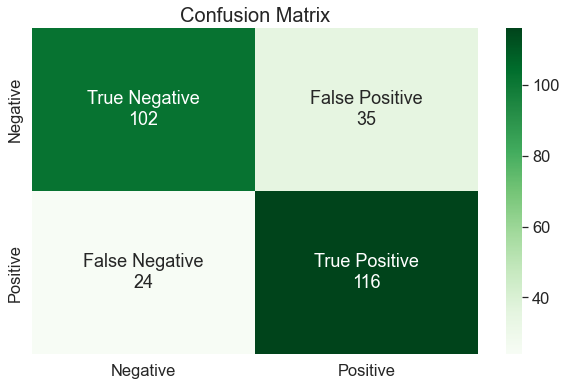

In [9]:
report(modelNB, test_X_vector, test_Y)

# PART 2 - Improving previous method for Car Review Classifier

### Libraries

Now, I am adding the following libraries for the Part 2 in the assignment.

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

As we can see in previous section the main offender is to implement a good and appropriate pre-processing, by normalizing or standardizing the raw data; this case, the "Sentiment" column takes the priority, and a simple column transformation for categorical values in “Review” column was a good approach to continue with the Naïve-Bayes solution as I described.
In this instance, it should be noticed that I tried with options for 4 conditions by using different libraries in natural language processing (NLTK and Spacy), spell checkers (autocorrect), stemmers / lemmatizers and n-grams up to 2:
1.	The first variable was the “stop_words” (words that might not add much value to the meaning of the review), whose list in larger in Spacy [1], one important part to mention is that we can delete or add any word that may be useful or not for our purpose, this time the main set did not was changed.
2.	The second variable was the use of stem and lemmatizer function (process of transforming a word into a single canonical form). Here NLTK library has feasible options to implement: Lemmatizer and variations of stemmer function such as PorterStemmer and SnowballStemmer, meanwhile spacy has only lemmatizer, (Stemmer: It is a rule-based process of stripping the suffixes (“ing”, “ly”, “es”, “s” etc) from a word, on the other hand Lemmatizer is an organized & step-by-step procedure of obtaining the root form of the word by using dictionary and morphological analysis [2]). 
Here we can notice that as result of lemmatizer function is more sophisticated than stem and even more in Spacy, the process time for this last one increases, so going back as I mentioned previously the default option for this parameter is “NLTK_Lemmatizer”, however I iterated over the 4 options mentioned ("NLTK_lemmatizer", “Spacy”, “NLTK_stemmer", "NLTK_snowball_stemmer") and compare each one based on accuracy result for the Naïve-Bayes Model.
3.	The third parameter was a spell checker, here we can find a variety of spellcheckers for python, and making a similar process like the stem parameter, I implemented and iterated over these 4 options: “NLTK_jaccard", "autocorrect", "Textblob", "pyspellchecker". 

Despite all of them do similar work to predict the possible misspelled word, their outputs are slightly different, we can see clearer in jaccard_diatance option, which is a measure of how dissimilar two sets are (source string and the target word). The lower the distance, the more similar the two strings, so we can create a function to edit that distance as convenience based on the source dictionaries, however it is an enormous job due to all words and their variations such as superlatives, similar words, etc. 

Pyspellchecker has a similar function to see the possible candidates for the misspelled word, on the other hand, autocorrect make the predictions based on some probabilities this is a great tool for automatic response, however any of them is perfect, so the accuracy for this type of models are around 70% to 80% for autocorrections. 
4.	The fourth parameter for processing data was implantation of n-grams, as I said in previous section: the default value is 1, and with this value I did the design of experiments for all options / parameters above.
I just iterated a 2-gram by using the default parameters in stop_words (“Spacy”), stemmer/Lemmatizer (“NLTK_Lemmatizer”) and I used the “autocorrect” option for spellchecker (default option is None).

All results can be seen in the following tables by using the same approach of K-fold cross validation parameters for training set (5 Folds, 3 repeats), based on that I selected the condition with “Spacy” for stop_words, “NLTK_Lemmatizer” for stemmer/ lemmatizer option and no spell checker, which showed an average accuracy between all the experiments and the process time was not too long, all this by using the Naives-Bayes Multinomial model and avoid the overfitting, to be used and improve the solution method of the classifier.

<img src="Images/Table_Accuaracy 1-gram all combinations for processing data.png" style="width: 70%;"/>

<img src="Images/Table_Accuaracy 2-gram one option for processing data.png" style="width: 70%;"/>

The following step I did was to try with 2 different models / classifiers “Logistic regression” and “Random forest classifier” whi the previous selected parameters, which are two very common and widely studied machine learning models as Kaitlin Kirasich, Trace Smith and Bivin Sadler described in their article “Random Forest vs Logistic Regression: Binary Classification for Heterogeneous Datasets” [3], in which they make a deep comparison with this 2 methods by changing different parameters and to measure the performance between the two models, they used the accuracy.

In order to iterate through all different combinations in the models I chose a few hyperparameters that affect the performance of the models and put them in a dictionary and to keep the results repeatable I used random state equals 1.

In addition, I created a function that repeat the process for all models and provides the best option for each one with its hyperparameters based on the best accuracy on the training model with repeated K-fold cross validation (5 Folds, 3 repeats) and the score for the test data with the tunned hyperparameters. All this by using the “Grid Search cv” method from Scikit library which makes an exhaustive search over specified parameter values (dictionaries) for an estimator.

2 more functions to create a dataframe with the summary and to plot the accuracy results can be found to visualize all the results at this instance.

For “Logistic Regression” the hyperparameters were: 

1.	Regularization technique: L1 and L2 (Approach to avoid overfitting in the model)

2.	Alpha: [0.001, 0.01, 0.1, 1, 10] (A factor that is used in regularization to penalize the model)

3.	Solver: ["liblinear"] (Algorithm to use in the model). I limited this option as result of according to scikit learn web site, “liblinear” is a great option for small data sets.

As result of the time that random forest classifier takes to run an iteration with “X” estimators (number of trees) and maximum depth of each one, I only ran 3 options of each parameter, so the hyperparameters are:

1.	Number of trees in the forest: [100, 200, 500]

2.	Minimum number of samples required to be at a leaf node: [1, 2]

3.	Maximum depth of the tree: [3, 6, 9]

In [11]:
# Defining all models to compare
models_list = [LogisticRegression(random_state = 1), RandomForestClassifier(random_state = 1)]

In [12]:
# Hyperparameters Linear Regression
params_grid_LR ={"penalty": ["l1", "l2"],
              "C": [1e-3, 1e-2, 0.1, 1, 10],
              "solver": ["liblinear"]
             }

# Hyperparameters RandomForestClassifier
params_grid_RF ={"n_estimators": [100, 200, 500],
                 "min_samples_leaf": [1, 2],
                 "max_depth": [3, 6, 9],                
             }

params_grid = [params_grid_LR, params_grid_RF]

In [13]:
def tuning_models(models_list, params_grid):
    ## Tunning hyperprameters based on training data
    Models = [(None, None, None, None)]
    
    print("\nTesting the models and finding the best hyperparameters")

    for i in range(len(models_list)):
        print("##################################################################")
        print(models_list[i])
        cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
        grid = GridSearchCV(models_list[i], param_grid = params_grid[i], cv = cv, n_jobs = -1, verbose = 4, scoring = "accuracy", error_score = 0)
        grid.fit(train_X_vector, train_Y)
        print()
        print(f"Estimator: {grid.best_estimator_}")
        print(f"Best parameters: {grid.best_params_}")
        print(f"Best score on Training Data: {100 * grid.best_score_:.2f}%")
        print(f"The Accuracy of the model with Testing Data is: {100 *grid.best_estimator_.score(test_X_vector, test_Y):.2f}%")
        print()
        Models.append((grid.best_estimator_, grid.best_params_, grid.best_score_, grid.best_estimator_.score(test_X_vector, test_Y)))
    return Models

In [14]:
def Summary_table(Models_Summary):
    
    print("\nCreating the Data Frame")
    Summary = pd.DataFrame(Models_Summary, columns=['Estimator','Best Parameters', 'Best Score with Training Set (%)', 'Score with Testing Set (%)'],)
    Summary = Summary.drop([0],axis=0)
    Summary['Best Score with Training Set (%)'] = Summary.loc[:,'Best Score with Training Set (%)'] * 100
    Summary['Score with Testing Set (%)'] = Summary.loc[:,'Score with Testing Set (%)'] * 100
    Summary["Estimator"] = Summary["Estimator"].astype(str)
    #Summary.to_csv('Summary_Results.csv', header=True, index=False)
    #print(Summary)
    return Summary

In [15]:
def Plotting_summary(Summary):

    print("\nPlotting the summary table")
    # Plotting all results with the models
    plt.figure(figsize=(10,6))
    sns.set(font_scale = 1.5, style='darkgrid', palette='bright', font='sans-serif', color_codes=True, rc=None)
    ax = sns.scatterplot(data = Summary, y = "Estimator", x = "Score with Testing Set (%)", s =100, label = "Testing Set")
    ax = sns.scatterplot(data = Summary, y = "Estimator", x = "Best Score with Training Set (%)", s =100, label = "Training Set")
    plt. xlabel ("Accuracy (%)")
    plt. ylabel ("Estimator")
    plt.title( "Estimators´ Accuracy" , size = 20 )
    plt.savefig("Estimators´ Accuracy.jpeg")
    plt.show()

Now, we can put all together and see the results.

1. tuning_models(models_list, params_grid): Receive the list of all models that will be tested and their parameters (dictionaries) and return a list with with a tuple of 4 (*.best_estimator_, *.best_params_, *.best_score_ [Based on training set], *.best_estimator_.score [Based on the tunned model and testing on test set])
2. Summary_table(Models_Summary): Receive a list with a tuple of 4 (*.best_estimator_, *.best_params_, *.best_score_ [Based on training set], *.best_estimator_.score [Based on the tunned model and testing on test set]) and create a dataframe, retunrung this as summary
3. Plotting_summary(Summary): Receive the dataframe "Summary" and plot all the results.


Testing the models and finding the best hyperparameters
##################################################################
LogisticRegression(random_state=1)
Fitting 15 folds for each of 10 candidates, totalling 150 fits

Estimator: LogisticRegression(C=0.1, random_state=1, solver='liblinear')
Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best score on Training Data: 78.97%
The Accuracy of the model with Testing Data is: 80.51%

##################################################################
RandomForestClassifier(random_state=1)
Fitting 15 folds for each of 18 candidates, totalling 270 fits

Estimator: RandomForestClassifier(max_depth=9, n_estimators=200, random_state=1)
Best parameters: {'max_depth': 9, 'min_samples_leaf': 1, 'n_estimators': 200}
Best score on Training Data: 75.96%
The Accuracy of the model with Testing Data is: 77.62%


Creating the Data Frame

Estimators´ Accuracy 1-gram & no spell checker

Plotting the summary table


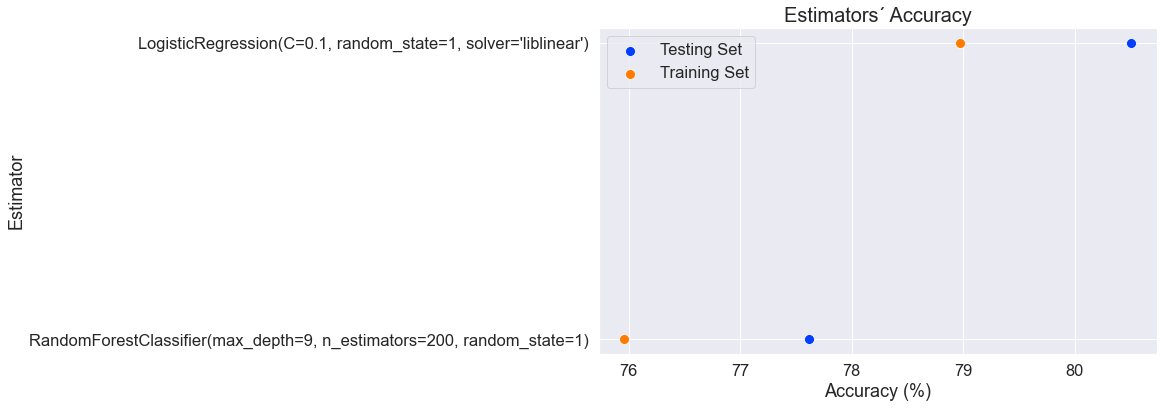


All models were tested


,Estimator,Best Parameters,Best Score with Training Set (%),Score with Testing Set (%)
1,"LogisticRegression(C=0.1, random_state=1, solv...","{'C': 0.1, 'penalty': 'l2', 'solver': 'libline...",78.974359,80.505415
2,"RandomForestClassifier(max_depth=9, n_estimato...","{'max_depth': 9, 'min_samples_leaf': 1, 'n_est...",75.957768,77.617329


In [16]:
Models_Summary = tuning_models(models_list, params_grid)
Summary = Summary_table(Models_Summary)
print(f"\nEstimators´ Accuracy 1-gram & no spell checker")
Plotting_summary(Summary)
print(f"\nAll models were tested")
Summary

Once that, I implemented the same methodology, this time using 4 more classifiers (check the list below to see all models used). The main purpose for this is to compare accuracy provided by each model in the list and select the one with the most proper hyperparameters to increase the accuracy of our results.
1.	GaussianNB()
2.	LogisticRegression()
3.	RandomForestClassifier()
4.	SVC()
5.	LinearSVC()
6.	SGDClassifier()
7.	KNeighborsClassifier()


In [17]:
# Defining all models
new_models_list = [MultinomialNB(), LogisticRegression(random_state = 1), SVC(random_state = 1), SVC(random_state = 1), LinearSVC(random_state=1), SGDClassifier(), KNeighborsClassifier(), RandomForestClassifier(random_state = 1)]

In [18]:
# Hyperparameters Linear Regression
params_grid_MNB ={"alpha": [0, 1, 2, 5],
              "fit_prior": [True, False]
             }

params_grid_LR ={"penalty": ["l1", "l2"],
              "C": [1e-3, 1e-2, 0.1, 1, 10],
              "solver": ["liblinear"]
             }

# Hyperparameters RandomForestClassifier
params_grid_RF ={"n_estimators": [100, 200, 500],
                 "min_samples_leaf": [1, 2],
                 "max_depth": [3, 6, 9],                
             }

# Hyperparameters SVC
params_grid_SVC_1 = {"kernel": ["rbf", "poly", "sigmoid"], 
                   "gamma": [1e-3, 1e-4], 
                   "C": [1e-3, 1e-2, 0.1, 1, 10]
                  }

params_grid_SVC_2 = {"kernel": ["linear"], 
                     "C": [1e-3, 1e-2, 0.1, 1, 10]
                    }

params_grid_linearSVC = {"penalty": ["l1", "l2"],
                     "C": [1e-3, 1e-2, 0.1, 1, 10]
                    }

params_grid_SGD = {"loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
                   "alpha" : [1e-3, 1e-2, 0.1, 1, 10],
                   "penalty": ["l2", "l1"],         
                  }

params_grid_KN = {"n_neighbors" : [x for x in range (0, 25)],
                   "weights" : ["uniform", "distance"],
                   "metric": ["euclidian", "manhattan"],         
                  }

new_params_grid = [params_grid_MNB, params_grid_LR, params_grid_SVC_1, params_grid_SVC_2, params_grid_linearSVC, params_grid_SGD, params_grid_KN, params_grid_RF]

One thing to be noticed, all results listed here ara based on the same K-Fold Cross Validation (Folds = 5 & repeats = 3), however in order to reduce the process time you can change the parameter "cv" in the tunning_models function (min.value = 2).

<img src="Images/Option for Cross-Validation.png" style="width: 70%;"/>


Testing the models and finding the best hyperparameters
##################################################################
MultinomialNB()
Fitting 15 folds for each of 8 candidates, totalling 120 fits

Estimator: MultinomialNB(alpha=1)
Best parameters: {'alpha': 1, 'fit_prior': True}
Best score on Training Data: 76.80%
The Accuracy of the model with Testing Data is: 78.70%

##################################################################
LogisticRegression(random_state=1)
Fitting 15 folds for each of 10 candidates, totalling 150 fits

Estimator: LogisticRegression(C=0.1, random_state=1, solver='liblinear')
Best parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best score on Training Data: 78.97%
The Accuracy of the model with Testing Data is: 80.51%

##################################################################
SVC(random_state=1)
Fitting 15 folds for each of 30 candidates, totalling 450 fits

Estimator: SVC(C=10, gamma=0.001, random_state=1)
Best parameters: {'C':

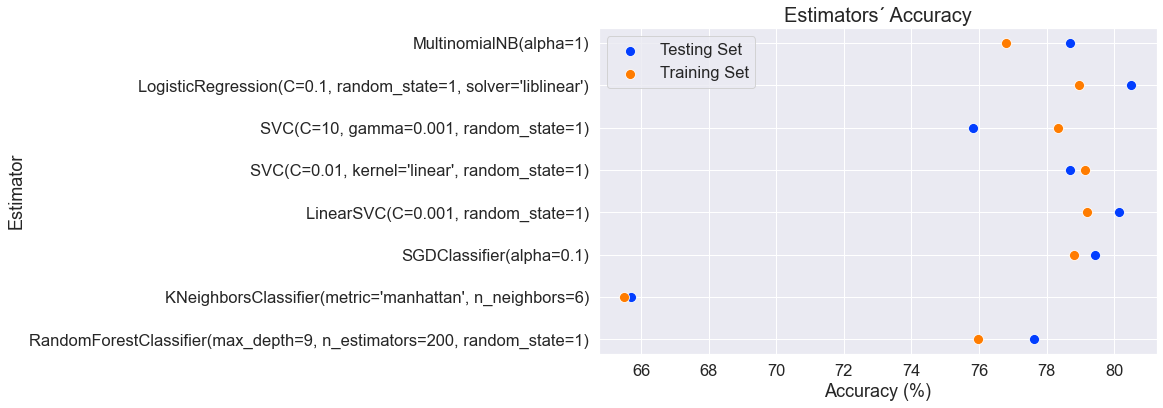


All models were tested


,Estimator,Best Parameters,Best Score with Training Set (%),Score with Testing Set (%)
1,MultinomialNB(alpha=1),"{'alpha': 1, 'fit_prior': True}",76.802413,78.700361
2,"LogisticRegression(C=0.1, random_state=1, solv...","{'C': 0.1, 'penalty': 'l2', 'solver': 'libline...",78.974359,80.505415
3,"SVC(C=10, gamma=0.001, random_state=1)","{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}",78.340875,75.812274
4,"SVC(C=0.01, kernel='linear', random_state=1)","{'C': 0.01, 'kernel': 'linear'}",79.125189,78.700361
5,"LinearSVC(C=0.001, random_state=1)","{'C': 0.001, 'penalty': 'l2'}",79.185520,80.144404
6,SGDClassifier(alpha=0.1),"{'alpha': 0.1, 'loss': 'hinge', 'penalty': 'l2'}",78.823529,79.422383
7,"KNeighborsClassifier(metric='manhattan', n_nei...","{'metric': 'manhattan', 'n_neighbors': 6, 'wei...",65.490196,65.703971
8,"RandomForestClassifier(max_depth=9, n_estimato...","{'max_depth': 9, 'min_samples_leaf': 1, 'n_est...",75.957768,77.617329


In [19]:
Models_Summary = tuning_models(new_models_list, new_params_grid)
Summary = Summary_table(Models_Summary)
print(f"\nEstimators´ Accuracy 1-gram & no spell checker")
Plotting_summary(Summary)
print(f"\nAll models were tested")
Summary

With all this in mind, I reroduced a last experiment,same parameters but this time with the second table presented above (2-gram), the results were saved on a csv file ("Summary_Results_2grams_autocorrect.csv"), which you can find in the folder. 

The reseults were:


Estimators´ Accuracy 2-gram & autocorection

Plotting the summary table


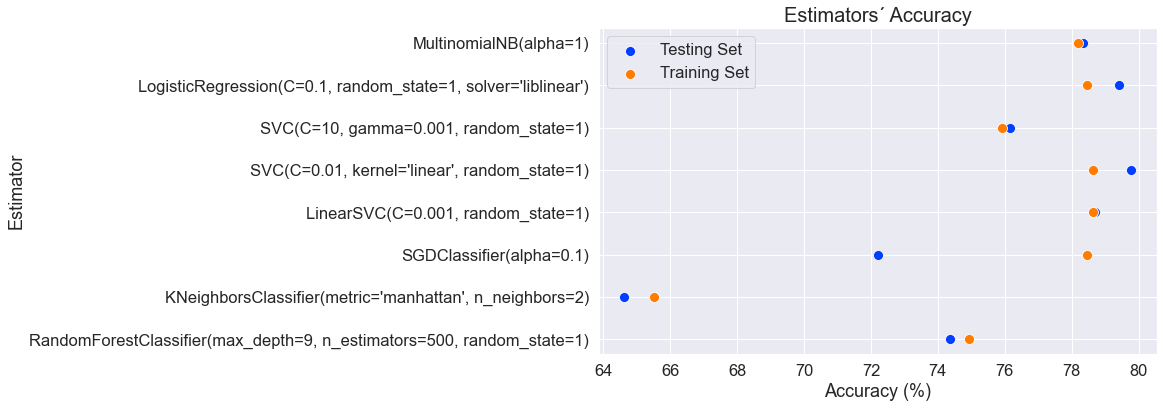

,Estimator,Best Parameters,Best Score with Training Set (%),Score with Testing Set (%)
0,MultinomialNB(alpha=1),"{'alpha': 1, 'fit_prior': True}",78.19,78.33
1,"LogisticRegression(C=0.1, random_state=1, solv...","{'C': 0.1, 'penalty': 'l2', 'solver': 'libline...",78.46,79.42
2,"SVC(C=10, gamma=0.001, random_state=1)","{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}",75.92,76.17
3,"SVC(C=0.01, kernel='linear', random_state=1)","{'C': 0.01, 'kernel': 'linear'}",78.64,79.78
4,"LinearSVC(C=0.001, random_state=1)","{'C': 0.001, 'penalty': 'l2'}",78.64,78.70
5,SGDClassifier(alpha=0.1),"{'alpha': 0.1, 'loss': 'hinge', 'penalty': 'l2'}",78.46,72.20
6,"KNeighborsClassifier(metric='manhattan', n_nei...","{'metric': 'manhattan', 'n_neighbors': 2, 'wei...",65.51,64.62
7,"RandomForestClassifier(max_depth=9, n_estimato...","{'max_depth': 9, 'min_samples_leaf': 1, 'n_est...",74.93,74.36


In [20]:
Summary_Results_2grams = pd.read_csv("Summary_Results_2grams_autocorrect.csv")
print(f"\nEstimators´ Accuracy 2-gram & autocorection")
Plotting_summary(Summary_Results_2grams)
Summary_Results_2grams

Looking at both data, we can see that the resuls from 1-gram and 2-gram have some variations in the accuracy (comparing each model with the other table), but we notice that the 1-gram results with its corresponding best parameters, the one which has the highest accuracy for test data was the LogisticRegression(C=0.1, random_state=1, solver='liblinear'), {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'} with 80.50%, increasing our initial value (78.70%) from Naive-Bayes Multinomial classifier for almost 1.8%. 

We can notice that more than 50% of the estimators overcame the initial value of accuracy and increased their results, but in diffrenet proportion. Now I will print the report and plot the confusion Matrix for each tunned & tested model for unigram results.


MultinomialNB(alpha=1)
Classification report for MultinomialNB(alpha=1) Classifier: 

              precision    recall  f1-score   support

           0       0.81      0.74      0.78       137
           1       0.77      0.83      0.80       140

    accuracy                           0.79       277
   macro avg       0.79      0.79      0.79       277
weighted avg       0.79      0.79      0.79       277



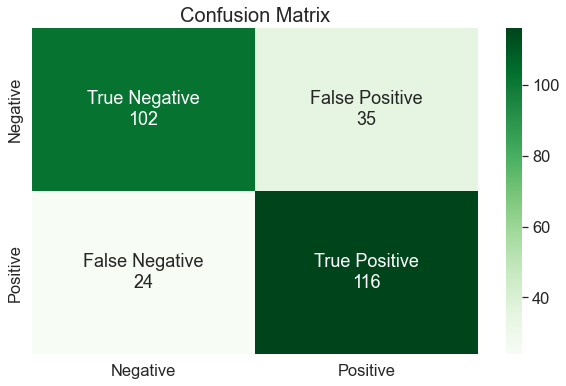


LogisticRegression(C=0.1, random_state=1, solver='liblinear')
Classification report for LogisticRegression(C=0.1, random_state=1, solver='liblinear') Classifier: 

              precision    recall  f1-score   support

           0       0.82      0.77      0.80       137
           1       0.79      0.84      0.81       140

    accuracy                           0.81       277
   macro avg       0.81      0.80      0.80       277
weighted avg       0.81      0.81      0.80       277



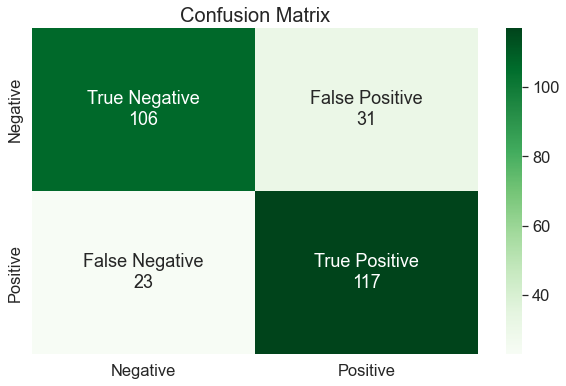


SVC(C=10, gamma=0.001, random_state=1)
Classification report for SVC(C=10, gamma=0.001, random_state=1) Classifier: 

              precision    recall  f1-score   support

           0       0.77      0.73      0.75       137
           1       0.75      0.79      0.77       140

    accuracy                           0.76       277
   macro avg       0.76      0.76      0.76       277
weighted avg       0.76      0.76      0.76       277



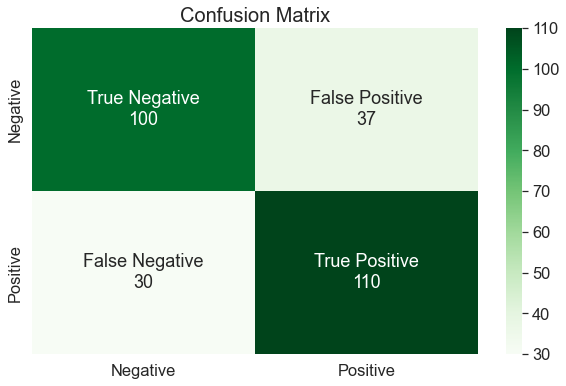


SVC(C=0.01, kernel='linear', random_state=1)
Classification report for SVC(C=0.01, kernel='linear', random_state=1) Classifier: 

              precision    recall  f1-score   support

           0       0.82      0.73      0.77       137
           1       0.76      0.84      0.80       140

    accuracy                           0.79       277
   macro avg       0.79      0.79      0.79       277
weighted avg       0.79      0.79      0.79       277



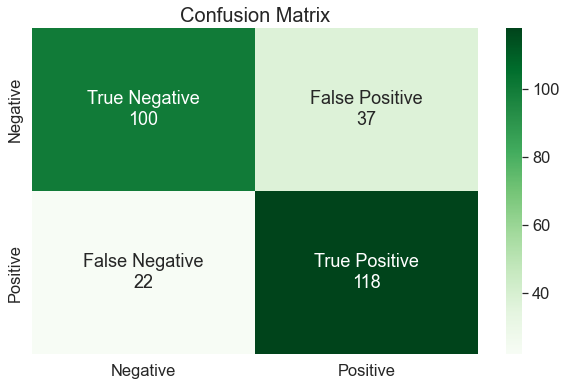


LinearSVC(C=0.001, random_state=1)
Classification report for LinearSVC(C=0.001, random_state=1) Classifier: 

              precision    recall  f1-score   support

           0       0.82      0.77      0.79       137
           1       0.79      0.83      0.81       140

    accuracy                           0.80       277
   macro avg       0.80      0.80      0.80       277
weighted avg       0.80      0.80      0.80       277



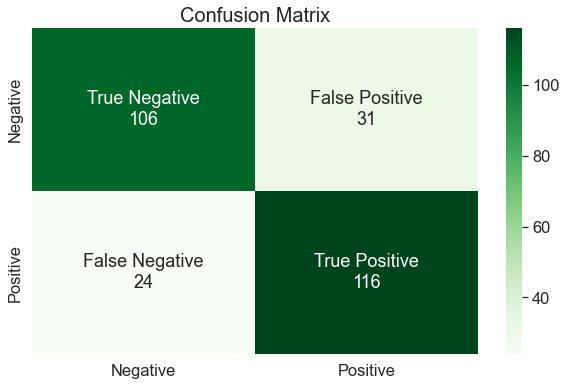


SGDClassifier(alpha=0.1)
Classification report for SGDClassifier(alpha=0.1) Classifier: 

              precision    recall  f1-score   support

           0       0.82      0.75      0.78       137
           1       0.77      0.84      0.80       140

    accuracy                           0.79       277
   macro avg       0.80      0.79      0.79       277
weighted avg       0.80      0.79      0.79       277



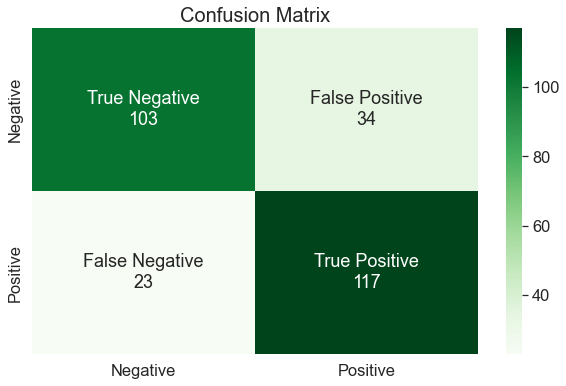


KNeighborsClassifier(metric='manhattan', n_neighbors=6)
Classification report for KNeighborsClassifier(metric='manhattan', n_neighbors=6) Classifier: 

              precision    recall  f1-score   support

           0       0.73      0.49      0.59       137
           1       0.62      0.82      0.71       140

    accuracy                           0.66       277
   macro avg       0.67      0.66      0.65       277
weighted avg       0.67      0.66      0.65       277



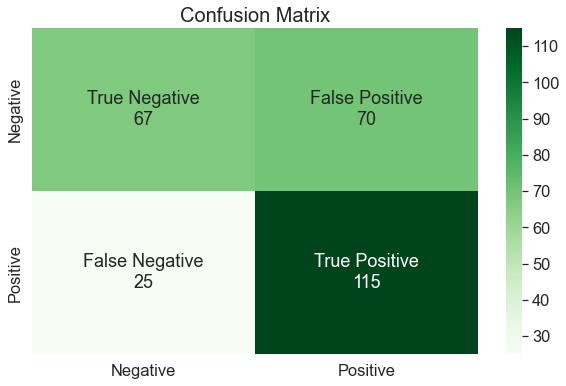


RandomForestClassifier(max_depth=9, n_estimators=200, random_state=1)
Classification report for RandomForestClassifier(max_depth=9, n_estimators=200, random_state=1) Classifier: 

              precision    recall  f1-score   support

           0       0.83      0.69      0.75       137
           1       0.74      0.86      0.79       140

    accuracy                           0.78       277
   macro avg       0.78      0.78      0.77       277
weighted avg       0.78      0.78      0.77       277



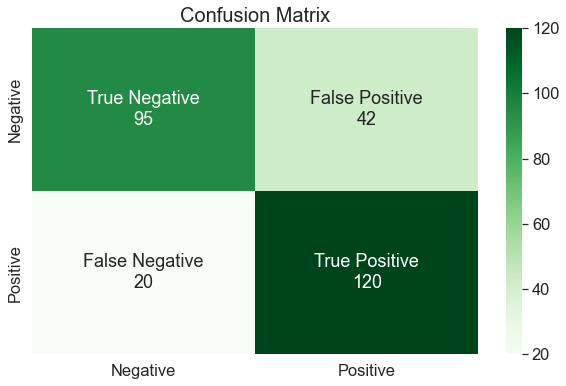

In [21]:
#Platting all Confusion Matrices

for i in range(len(Models_Summary)-1):
    print(f"\n{Models_Summary[i+1][0]}")
    report(Models_Summary[i+1][0], test_X_vector, test_Y)

### Extra Info.

To process just input & output data separately (Sentimnet / Review), you can use the following functions

In [22]:
def processing_data_X(data, num_grams, stop_words, stemmer, spell_checker):
    processed_data = Data_Ingestion_Processed(data) # Creating the object for training data
    data = data.apply(lambda x: x.astype(str).str.lower()) # Change to lower case
    data_X = data["Review"].to_list()
    data_X = processed_data.replace_contractions(data_X[0:]) # Processing contractions 
    data_X_tokenaize = processed_data.tokenaizer(data_X, num_grams) # Tokenaizing the text
    excluded_features_data_X = processed_data.excluding_data(data_X_tokenaize, stop_words, stemmer, spell_checker) # Excluding words, numbers, punctuations and returning a string
    return excluded_features_data_X

def processing_data_Y(data):
    
    processed_data = Data_Ingestion_Processed(data) # Creating the object for training data
    data = data.apply(lambda x: x.astype(str).str.lower()) # Change to lower case
    data_Y = data["Sentiment"]
    encoded_data_Y = processed_data.encoding_categorical_targets(data_Y) # Encoding target values Y data
    return encoded_data_Y


### Examples

In [23]:
# EXAMPLES
X = pd.read_csv("X.csv")
X_data = processing_data_X(X, num_grams = 1, stop_words = "Spacy", stemmer = "NLTK_lemmatizer", spell_checker = None) # Process and Normalize both "Features" X_Data and "Target values" (Y_Data)
# Bag of words
vectorizer = CountVectorizer() # Initializing the Object 
X_vector = vectorizer.fit_transform(X_data).toarray() # Transforming to bag of words
features = vectorizer.get_feature_names() # All words in a list
#print()
#print(train_features)
#print(len(train_features))

np.set_printoptions(threshold=np.inf)
print(X_vector) # Printing the reviews: Array that contains the number of times a word is repeated
print("\nDone")

Y = pd.read_csv("Y.csv")
Y_data = processing_data_Y(Y) # Process "Target values" (Y_Data)

np.set_printoptions(threshold=np.inf)
print(Y_data) # List of 0s or 1s
print("\nDone")


[[0 1 0 0 1 0 2 0 0 1 1 1 1 1 0 0 0 1 0 0 1 1 1 1 1 1 0 1 1 0 0 0 0 0 1 0
  0 1 0 0 0 0 1 1 0 1 0 1 0 0 1 0 0 1 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 3 1 2
  0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 2 0 0 1 0 1 0 1 1 3 0 0 1 1 3 1 0 1
  0 1 0 0 0 1 0 0 0 0 1 1 0 0 0]
 [1 0 1 1 0 1 0 1 2 1 7 0 0 0 1 1 5 2 1 1 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1
  1 0 2 1 1 1 0 0 1 0 1 0 1 1 0 2 1 0 1 0 0 1 3 2 1 2 0 1 1 0 1 0 1 0 0 0
  1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 2 0 1 0 1 0 0 0 1 1 0 0 5 0 1 0
  2 0 1 7 1 0 4 1 1 1 0 0 1 1 1]]

Done
[1 0 0 0 1]

Done


### Conclusion
Although GridSearchCV tool has numerous benefits for the design of experiments, it is not a good approach to spend too much time perfectly tuning the model. A better use of time may be to investigate the features further (inputs / raw data), as we can see, implementing different spell checkers, lemmatizers, n-grams, etc helped in some instances to increase (or decrease) the performance of the model.

This will take much more time and effort and we can only pass to the scikit learn method to make the final little fine-tuning, it should be noticed that we can develop the understanding of the dataset and possibly discover new relationships between features if we correctly process the raw data (Normalizing or Standardizing).

As I mentioned above, there was an improvement by using the GridSearchCV method, but it was not so huge as I expected (1.8% - best case). We can implement other methods like ANN to see and compare the results but the critical part always be how can we manage / process the raw data.

### References

[1]. C. Khanna, Towards data science - Text pre-processing: Stop words removal using different libraries <https://towardsdatascience.com/text-pre-processing-stop-words-removal-using-different-libraries-f20bac19929a>

[2]. S. Singh, Analytics Vidhya - NLP Essentials. Accessed 30 November 2021. <https://www.analyticsvidhya.com/blog/2019/08/how-to-remove-stopwords-text-normalization-nltk-spacy-gensim-python/>

[3]. Kirasich, Kaitlin; Smith, Trace; and Sadler, Bivin (2018) "Random Forest vs Logistic Regression: Binary Classification for Heterogeneous Datasets," SMU Data Science Review: Vol. 1: No. 3, Article 9. Available at: https://scholar.smu.edu/datasciencereview/vol1/iss3/9

[4]. J. Brownlee - Repeated k-Fold Cross-Validation for Model Evaluation in Python. Accessed 25 November 2021. <https://machinelearningmastery.com/repeated-k-fold-cross-validation-with-python/>
